# Random Forest Classifier - Fitting hospital-specific models

## Aims

Assess accuracy of a random forest classifier, using k-fold (5-fold) training/test data splits (each data point is present in one and only one of the five test sets). This notebook fits models to each hospital independently.

The notebook includes:

* A range of accuracy scores
* Receiver operating characteristic (ROC) and Sensitivity-Specificity Curves 

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Load train and test set data

K-fold train/test split has previously been performed. Train/test data is stratified by hospital and thrombolysis.

In [2]:
# Lists to hold data splits
train_splits = []
train_splits_one_hot_hosp = []
test_splits = []
test_splits_one_hot_hosp = []

# Loop to load data and add to lists
for i in range (5):
    train_splits.append(pd.read_csv(f'../data/kfold_5fold/train_{i}.csv'))
    test_splits.append(pd.read_csv(f'../data/kfold_5fold/test_{i}.csv'))    

## Functions

### Find model probability threshold to match predicted and actual thrombolysis use

In [3]:
def find_threshold(probabilities, true_rate):
    
    """
    Find classification threshold to calibrate model
    """
    
    index = (1-true_rate)*len(probabilities)
    
    threshold = sorted(probabilities)[int(index)]
    
    return threshold

### Calculate accuracy measures

In [4]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

### Line intersect

Used to find point of sensitivity-specificity curve where sensitivity = specificity.

In [5]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

## Fit hospital-specific models

In [6]:
hospitals = set(train_splits[0]['StrokeTeam'])

In [7]:
# Set up list to store models and calibration thresholds
hospital_models = []
thresholds = []

# Set up lists for results
observed = []
predicted_proba = []
predicted = []
kfold_result = []
hospital_results = []
threshold_results = []
feature_data = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_splits[k_fold]
    test = test_splits[k_fold]
    
    # Loop through hospitals
    for hospital in hospitals:
        
        # Get X and y
        mask = train['StrokeTeam'] == hospital
        X_train = train[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)    
        y_train = train.loc[mask]['S2Thrombolysis']
        
        mask = test['StrokeTeam'] == hospital
        X_test = test[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
        y_test = test.loc[mask]['S2Thrombolysis']
        feature_data.append(test[mask])
        
        # Define model
        forest = RandomForestClassifier(
            n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)

        # Fit model
        forest.fit(X_train, y_train)

        # Get predicted probabilities
        y_probs = forest.predict_proba(X_test)[:,1]
        
        # Calibrate model and get class
        true_rate = np.mean(y_test)
        threshold = find_threshold(y_probs, true_rate)
        thresholds.append(threshold)
        y_class = y_probs >= threshold
        y_class = np.array(y_class) * 1.0
        
        # Store results
        observed.extend(list(y_test))
        predicted_proba.extend(list(y_probs))
        predicted.extend(y_class)
        kfold_result.extend(list(np.repeat(k_fold, len(y_test))))
        hospital_results.extend(list(np.repeat(hospital, len(y_test))))
        threshold_results.extend(np.repeat(threshold, len(y_test)))       
        

In [8]:
feature_data_df = pd.concat(feature_data, axis=0)

In [9]:
# Collate patient-level results
multi_model = pd.DataFrame()
multi_model['hospital'] = hospital_results
multi_model['observed'] = np.array(observed) * 1.0
multi_model['prob'] = predicted_proba
multi_model['predicted'] = predicted
multi_model['k_fold'] = kfold_result
multi_model['threshold'] = threshold_results
multi_model['correct'] = multi_model['observed'] == multi_model['predicted']

# Save model
filename = './predictions/multi_fit_rf_k_fold.csv'
multi_model.to_csv(filename, index=False)

# Save features
feature_data_df.to_csv('./predictions/feature_data.csv')

## Results

### Accuracy measuresto_csv

In [10]:
k_fold_results = []

for i in range(5):
    mask = multi_model['k_fold'] == i
    mask = mask.values
    observed = multi_model.loc[mask]['observed']
    predicted = multi_model.loc[mask]['predicted']
    results = calculate_accuracy(observed, predicted)
    k_fold_results.append(results)
    
multi_fit_results = pd.DataFrame(k_fold_results).T

In [11]:
multi_fit_results

,0,1,2,3,4
observed_positive_rate,0.295232,0.295401,0.295176,0.295080,0.295417
observed_negative_rate,0.704768,0.704599,0.704824,0.704920,0.704583
predicted_positive_rate,0.300405,0.300292,0.300292,0.300703,0.299972
predicted_negative_rate,0.699595,0.699708,0.699708,0.699297,0.700028
accuracy,0.843023,0.843866,0.843079,0.843351,0.842508
precision,0.730114,0.731885,0.730200,0.730180,0.729897
recall,0.742906,0.744005,0.742857,0.744093,0.741150
f1,0.736455,0.737895,0.736474,0.737071,0.735480
sensitivity,0.742906,0.744005,0.742857,0.744093,0.741150
specificity,0.884962,0.885733,0.885051,0.884901,0.885005


In [12]:
multi_fit_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.295261,0.704739,0.300333,0.699667,0.843165,0.730455,0.743002,0.736675,0.743002,0.885130,6.468272,0.290351,0.114870,0.256998,0.743002,0.885130,0.730455,0.891546
std,0.000146,0.000146,0.000263,0.000263,0.000496,0.000808,0.001189,0.000889,0.001189,0.000341,0.025116,0.001390,0.000341,0.001189,0.001189,0.000341,0.000808,0.000495
min,0.295080,0.704583,0.299972,0.699297,0.842508,0.729897,0.741150,0.735480,0.741150,0.884901,6.445070,0.289021,0.114267,0.255907,0.741150,0.884901,0.729897,0.890763
25%,0.295176,0.704599,0.300292,0.699595,0.843023,0.730114,0.742857,0.736455,0.742857,0.884962,6.457925,0.289193,0.114949,0.255995,0.742857,0.884962,0.730114,0.891505
50%,0.295232,0.704768,0.300292,0.699708,0.843079,0.730180,0.742906,0.736474,0.742906,0.885005,6.462496,0.290514,0.114995,0.257094,0.742906,0.885005,0.730180,0.891523
75%,0.295401,0.704824,0.300405,0.699708,0.843351,0.730200,0.744005,0.737071,0.744005,0.885051,6.464791,0.290540,0.115038,0.257143,0.744005,0.885051,0.730200,0.891924
max,0.295417,0.704920,0.300703,0.700028,0.843866,0.731885,0.744093,0.737895,0.744093,0.885733,6.511079,0.292485,0.115099,0.258850,0.744093,0.885733,0.731885,0.892016


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [13]:
k_fold_fpr = []
k_fold_tpr = []
k_fold_thresholds = []
k_fold_auc = []

for i in range(5):
    mask = multi_model['k_fold'] == i
    mask = mask.values
    observed = multi_model.loc[mask]['observed']
    predicted_proba = multi_model.loc[mask]['prob']
    fpr, tpr, thresholds = roc_curve(observed, predicted_proba)
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    print (f'Run {i} AUC {roc_auc:0.4f}')
    
# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.9073
Run 1 AUC 0.9056
Run 2 AUC 0.9057
Run 3 AUC 0.9066
Run 4 AUC 0.9041

Mean AUC: 0.9059
SD AUC: 0.0011


Sensitivity-specificity curve:

In [14]:
k_fold_sensitivity = []
k_fold_specificity = []


for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    mask = multi_model['k_fold'] == i
    mask = mask.values
    observed = multi_model.loc[mask]['observed']
    predicted_proba = multi_model.loc[mask]['prob']
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_class = predicted_proba >= cutoff
        predicted_class = predicted_class.values * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(observed, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Combined plot:

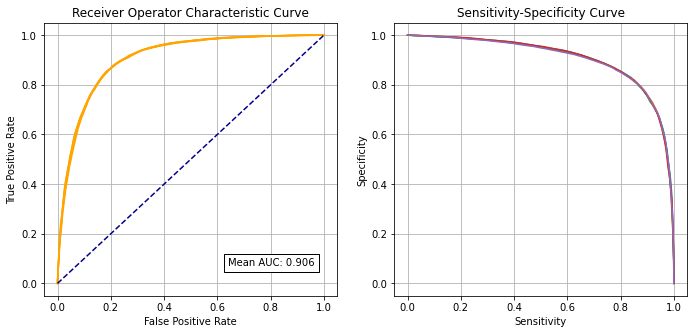

In [15]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig('./output/rf_hospital_fit_roc_sens_spec.jpg', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [16]:
sens = np.array(k_fold_sensitivity).mean(axis=0)
spec = np.array(k_fold_specificity).mean(axis=0)
df = pd.DataFrame()
df['sensitivity'] = sens
df['specificity'] = spec
df['spec greater sens'] = spec > sens

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersect = get_intersect(a1, a2, b1, b2)[0]
print(f'\nIntersect: {intersect:0.3f}')


Intersect: 0.832


### Learning Curves 

Examine the relationship between training data size and accuracy

In [17]:
hospitals = list(hospitals)

In [18]:
# Set up list to collect results 
hospital_results_training_size = []
hospital_results_accuracy = []
hospital_results_all_accuracy = []

for hospital in hospitals:
    
    # Set up list to collect results at hospital level
    results_training_size = []
    results_accuracy = []
    results_all_accuracy = []

    # Get maximum training size (number of training records)
    max_training_size = train_splits[0].loc[train_splits[0]\
                                            ['StrokeTeam']==hospital].shape[0]
    step = 50
        
    train_sizes = np.arange(10,max_training_size+1, step, dtype=int)

    # Loop through training sizes
    for train_size in train_sizes:

        # Record accuracy across k-fold replicates
        replicate_accuracy = []

        for replicate in range(5):

            # Get training and test data (from first k-fold split)
            train = train_splits[0]
            test = test_splits[0] 

            # Sample from training data
            patients_train = train.loc[train['StrokeTeam'] == hospital]
            patients_train = patients_train.sample(n=train_size)
            patients_test = test.loc[test['StrokeTeam'] == hospital]
            
            # Get X and y
            X_train = patients_train.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
            X_test = patients_test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
            y_train = patients_train['S2Thrombolysis']
            y_test = patients_test['S2Thrombolysis']      


            # Define model
            forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                                class_weight='balanced', random_state=42)

            # Fit model
            forest.fit(X_train, y_train)

            # Predict test set
            y_pred_test = forest.predict(X_test)

            # Get accuracy and record results
            accuracy = np.mean(y_pred_test == y_test)
            replicate_accuracy.append(accuracy)
            results_all_accuracy.append(accuracy)

        # Store mean accuracy across the k-fold splits
        results_accuracy.append(np.mean(replicate_accuracy))
        results_training_size.append(train_size)
        
    hospital_results_training_size.append(results_training_size)
    hospital_results_accuracy.append(results_accuracy)

    k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)
    
    hospital_results_all_accuracy.append(k_fold_accuracy)

Plot learning curves

In [19]:
def find_mean(lists):
    """
    Function to find means across multiple learning curves (with different 
    lengths)"""
    
    means = []
    
    max_len = max([len(row) for row in lists])
    
    for i in range(max_len):
        
        total = 0
        count = 0
        
        for row in lists:
            
            if len(row)>i:
                
                total+=row[i]
                count+=1
                
        means.append(total/count)
        
    return means

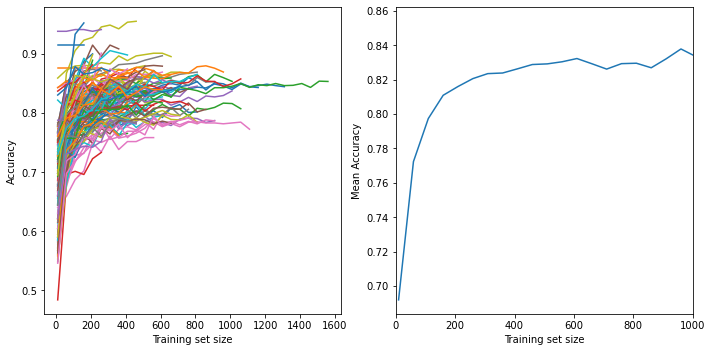

In [20]:
fig= plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for h in range(len(hospitals)):
    plt.plot(hospital_results_training_size[h], hospital_results_all_accuracy[h].mean(axis=1))

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy')


ax2 = fig.add_subplot(122)

arr = [hospital_results_all_accuracy[h].mean(axis=1)\
                     for h in range(len(hospitals))]

means = find_mean(arr)

ax2.plot(np.arange(10, (len(means))*step, step), means)

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Mean Accuracy')
ax2.set_xlim(0, 1000)


plt.tight_layout()
plt.savefig('./output/rf_single_learning_curve.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [21]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    mask = multi_model['k_fold'] == i
    obs = multi_model[mask]['observed'].values
    prob = multi_model[mask]['prob'].values
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
        
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [22]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.047576,0.011786,0.988214,0.263078
0.2,0.139816,0.055897,0.944103,0.209956
0.3,0.246119,0.187581,0.812419,0.130544
0.4,0.349228,0.371647,0.628353,0.081246
0.5,0.444228,0.528285,0.471715,0.081841
0.6,0.544184,0.681762,0.654011,0.077343
0.7,0.648681,0.783834,0.783834,0.077433
0.8,0.746637,0.865628,0.865628,0.048410
0.9,0.834920,0.893544,0.893544,0.026370


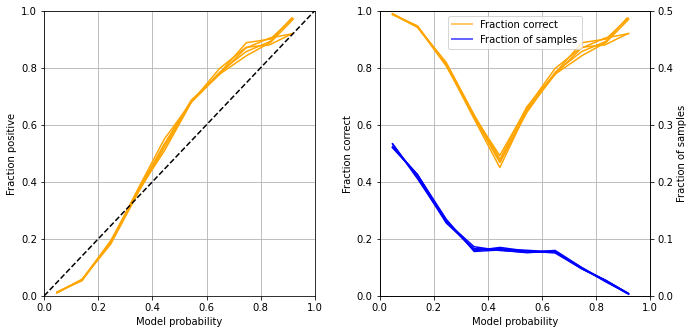

In [23]:
fig = plt.figure(figsize=(10,5))


# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.grid()

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid()

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha=0.6, lw=2)]

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)
plt.savefig('./output/rf_hospital_fit_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [24]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.503
Accuracy: 0.944


## Observations

* Fitting at a single hospital level gave an accuracy of 84.3% (c.f. 84.6% for a single model), and a ROC AUC of 0.906 (c.f. 0.914 for a single fit model)
* Accuracy was 94.4% for the 50% of samples with at least 80% confidence of model
* The model can achieve 83.2% sensitivity and specificity simultaneously